У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd

store_df = pd.read_csv("train.csv.zip", compression="zip")

store_df["date"] = pd.to_datetime(store_df["date"])

store_df.set_index("date", inplace=True)

print(store_df.head(10))
print(store_df.info())
print(store_df["item"].unique())
print(store_df["store"].unique())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
[ 1  2  3  4  5  6  7  8  9 10]


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



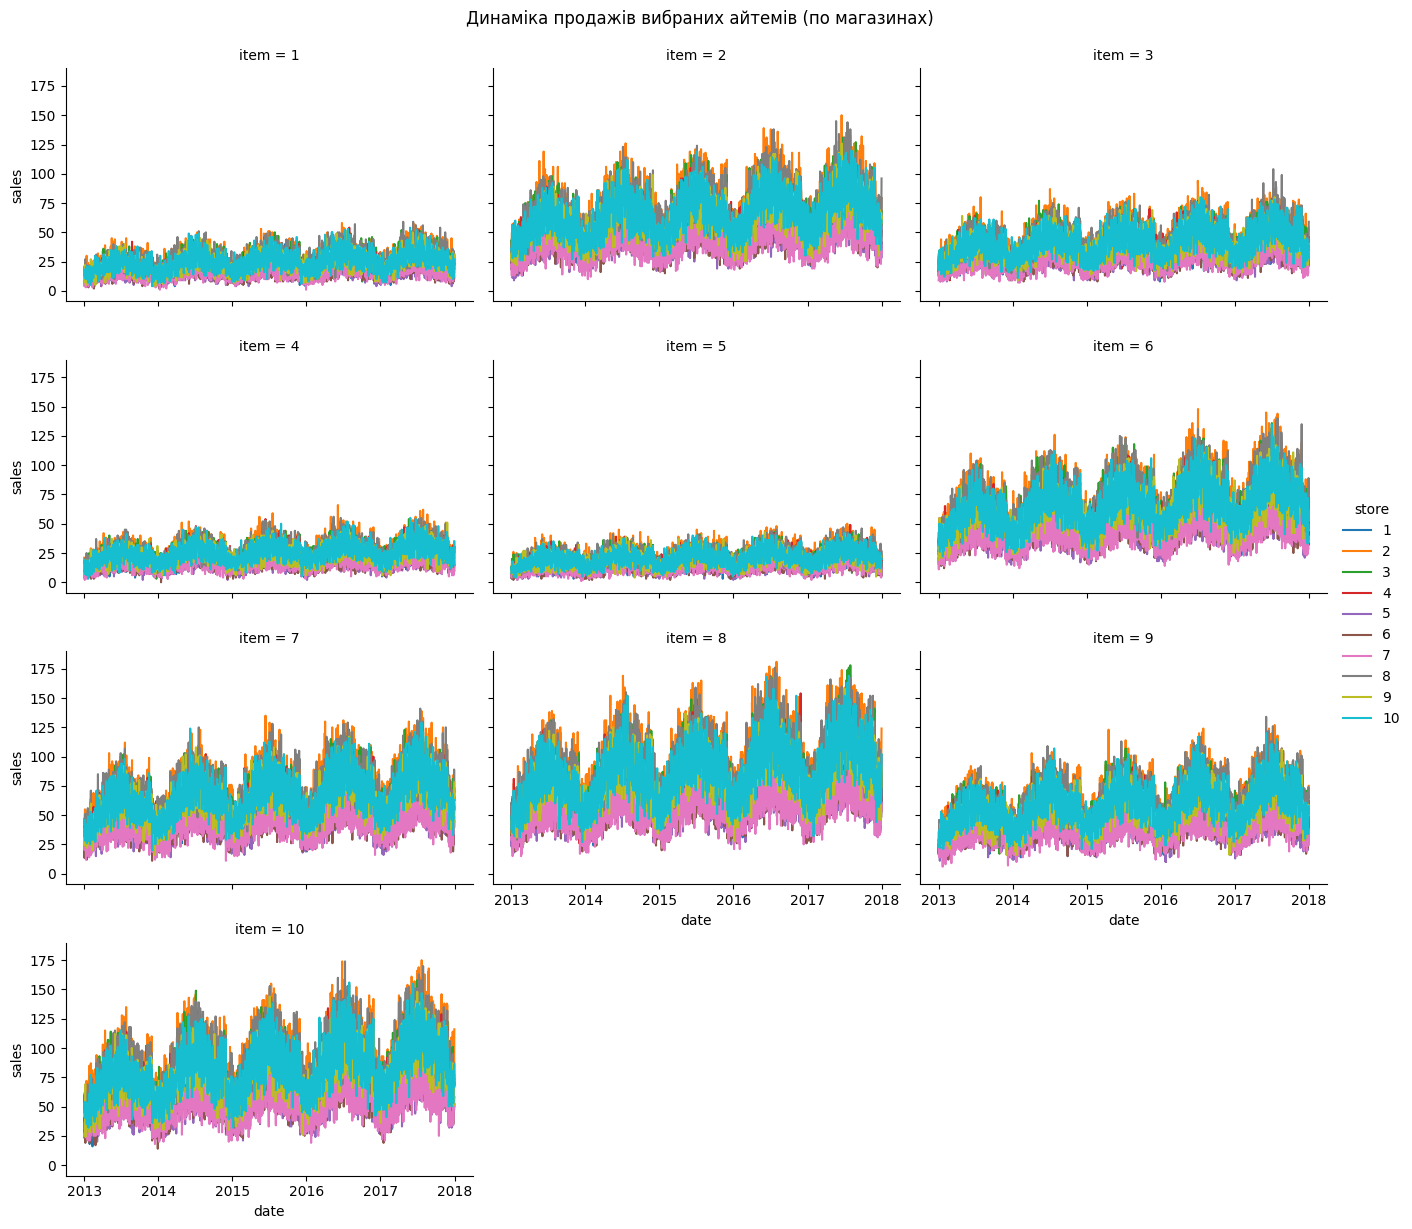

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_items = store_df['item'].unique()[:10]
subset_df = store_df[store_df['item'].isin(selected_items)].reset_index()

g = sns.FacetGrid(subset_df, col="item", hue="store", col_wrap=3, height=3, aspect=1.5)
g.map(sns.lineplot, "date", "sales").add_legend()
g.fig.suptitle("Динаміка продажів вибраних айтемів (по магазинах)", y=1.02)
plt.show()


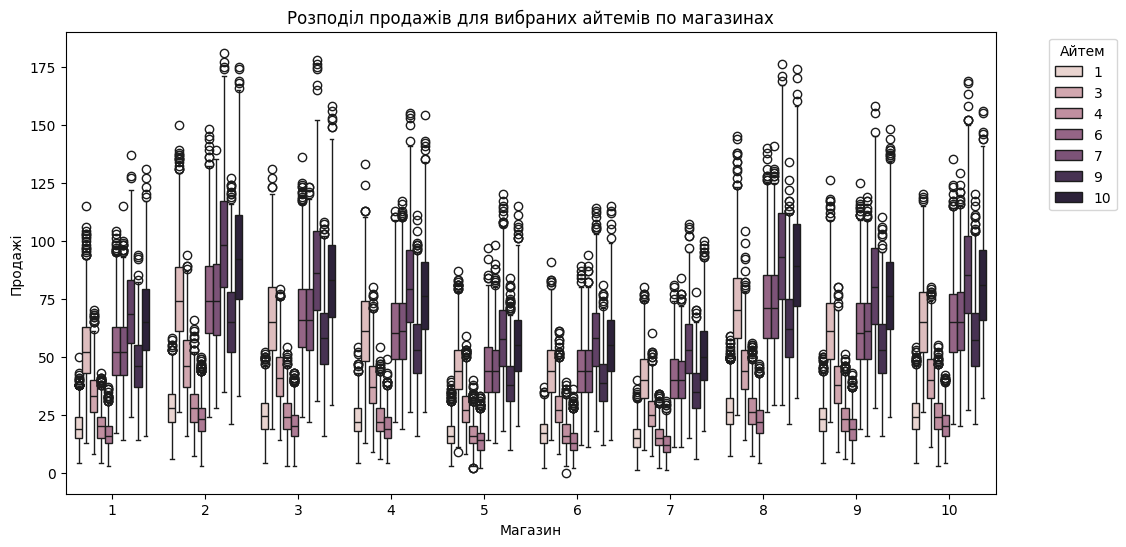

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_df, x="store", y="sales", hue="item")
plt.title("Розподіл продажів для вибраних айтемів по магазинах")
plt.xlabel("Магазин")
plt.ylabel("Продажі")
plt.legend(title="Айтем", bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


<ipython-input-4-a5af8e2a87a8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_sales, x="store", y="sales", palette="viridis")


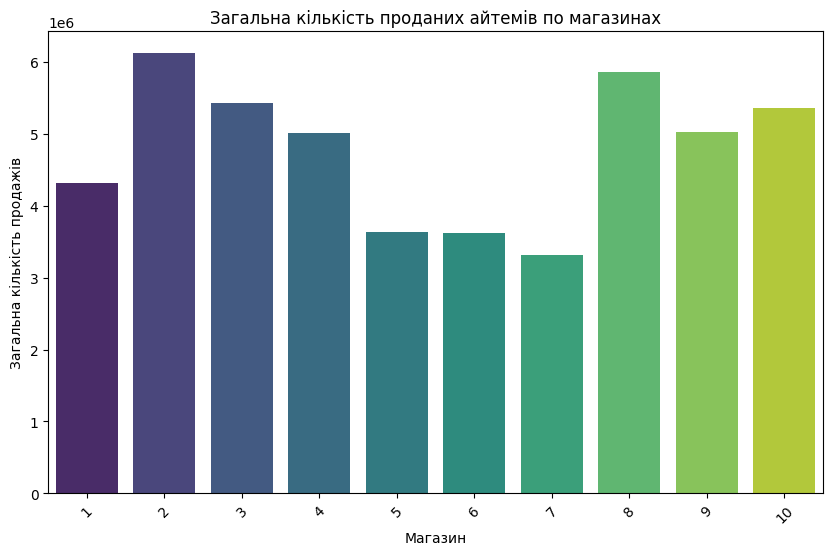

In [4]:
store_sales = store_df.groupby("store")["sales"].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=store_sales, x="store", y="sales", palette="viridis")

plt.title("Загальна кількість проданих айтемів по магазинах")
plt.xlabel("Магазин")
plt.ylabel("Загальна кількість продажів")
plt.xticks(rotation=45)
plt.show()


1. Спостерігаємо, що магазини здебільшого мають різні загальні кількості продажів (графік 3). Є магазини з більшим обсягом продажів, а є з меншим.
2. На першому графіку бачимо, що обсяги продажів у відсотковому співвідношення кожного айтему у різних магазинах співпадає.
3. Загалом спостерігаємо незначний висхідний тренед у продажах.
4. У 5 та 6 магазинах обʼєми продажів майже однакові. При цьому бачимо на другому графіку, що розподіл продажів конкретних товарів теж майже однаковий.  

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

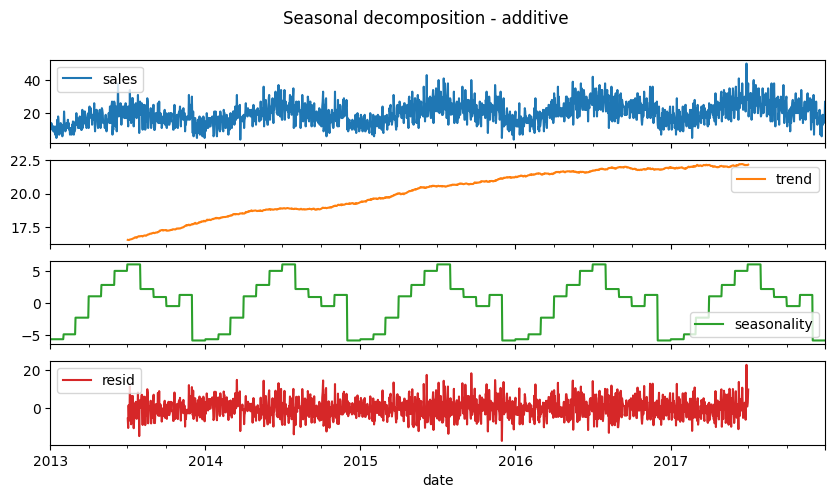

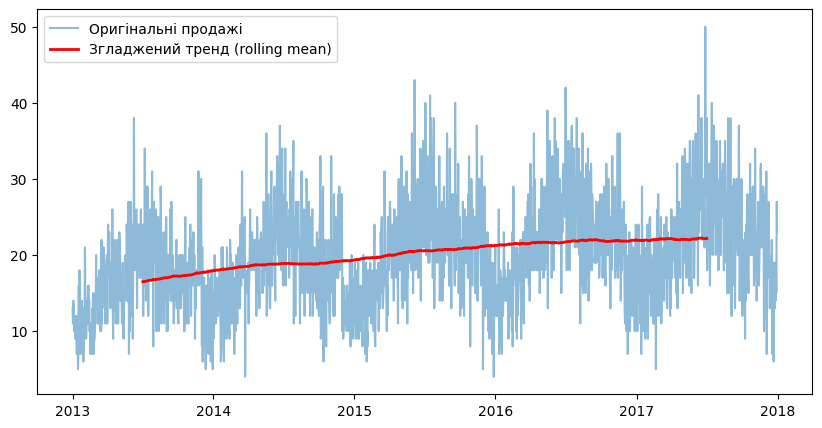

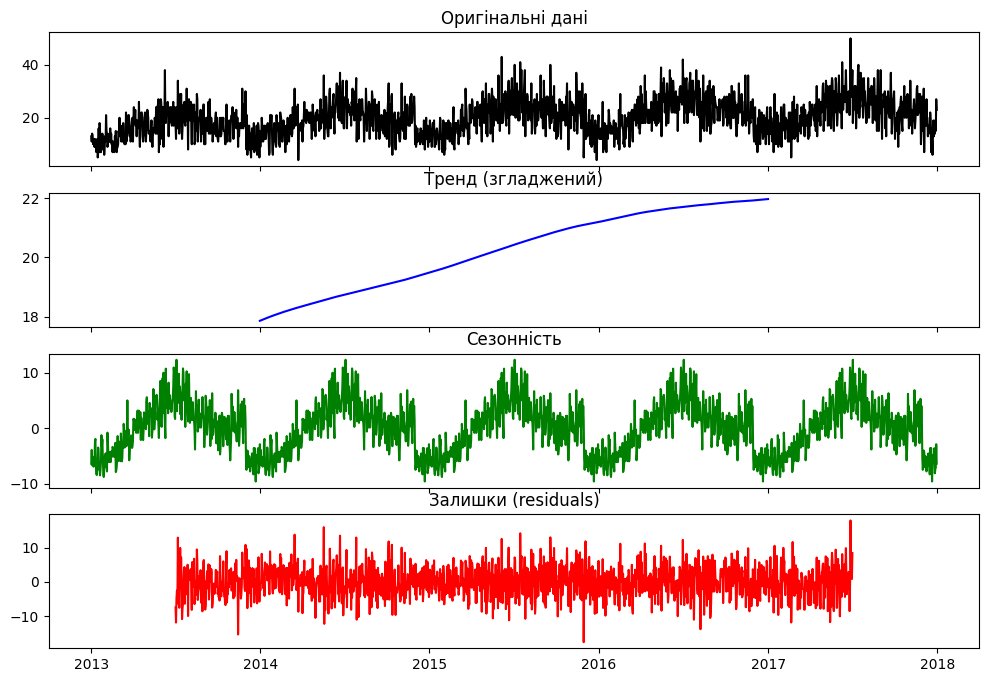

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

item1_store1_sales = store_df[(store_df["item"] == 1) & (store_df["store"] == 1)].copy()

item1_store1_sales["date"] = pd.to_datetime(item1_store1_sales.index)
item1_store1_sales.set_index("date", inplace=True)

df_additive = item1_store1_sales.copy(deep=True)

df_additive["trend"] = df_additive["sales"].rolling(window=365, center=True).mean()

df_additive["detrended"] = df_additive["sales"] - df_additive["trend"]

df_additive["month"] = df_additive.index.month
df_additive["seasonality"] = df_additive.groupby("month")["detrended"].transform("mean")

df_additive["resid"] = df_additive["detrended"] - df_additive["seasonality"]

(
    df_additive
    .loc[:, ["sales", "trend", "seasonality", "resid"]]
    .plot(subplots=True, title="Seasonal decomposition - additive", figsize=(10,5))
);


plt.figure(figsize=(10,5))
plt.plot(df_additive["sales"], label="Оригінальні продажі", alpha=0.5)
plt.plot(df_additive["trend"], label="Згладжений тренд (rolling mean)", color="red", linewidth=2)
plt.legend()
plt.show()


# statsmodels
decomposition = seasonal_decompose(item1_store1_sales['sales'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(decomposition.observed, color="black")
axes[0].set_title("Оригінальні дані")

smoothed_trend = decomposition.trend.rolling(window=365, center=True).mean()
axes[1].plot(smoothed_trend, color="blue")
axes[1].set_title("Тренд (згладжений)")

axes[2].plot(decomposition.seasonal, color="green")
axes[2].set_title("Сезонність")

axes[3].plot(decomposition.resid, color="red")
axes[3].set_title("Залишки (residuals)")
plt.show()


1. Спостерігаєтья незнайчний віисхідний тренд рік до року.
2. Прослідчується чітка сезонність.
3. Бачимо, що залишки зосереджені навколо нуля, але мають доволі широкий діапазог від -10 до 10. Хоча якогось патерну для них немає - це добре.

**4**. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [6]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.0/981.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.7 MB/s eta 0:00:00

In [7]:
from darts import TimeSeries

df_additive.index = pd.to_datetime(df_additive.index)

sales_series = TimeSeries.from_dataframe(df_additive, value_cols=['sales'])

sales_series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

<Axes: xlabel='date'>

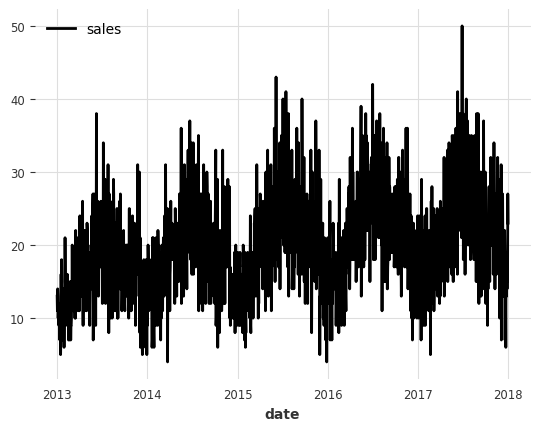

In [8]:
sales_series.plot()

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

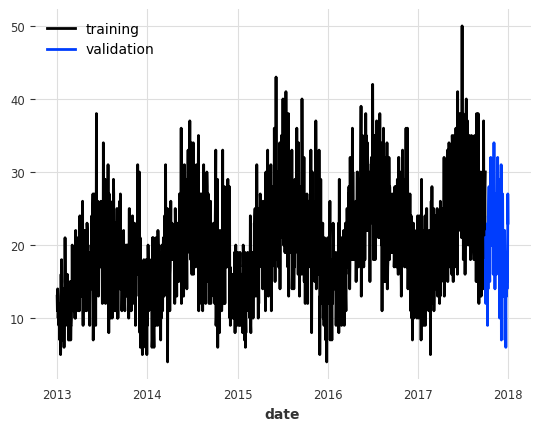

In [9]:
train, val = sales_series.split_before(pd.Timestamp('2017-10-01'))

train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

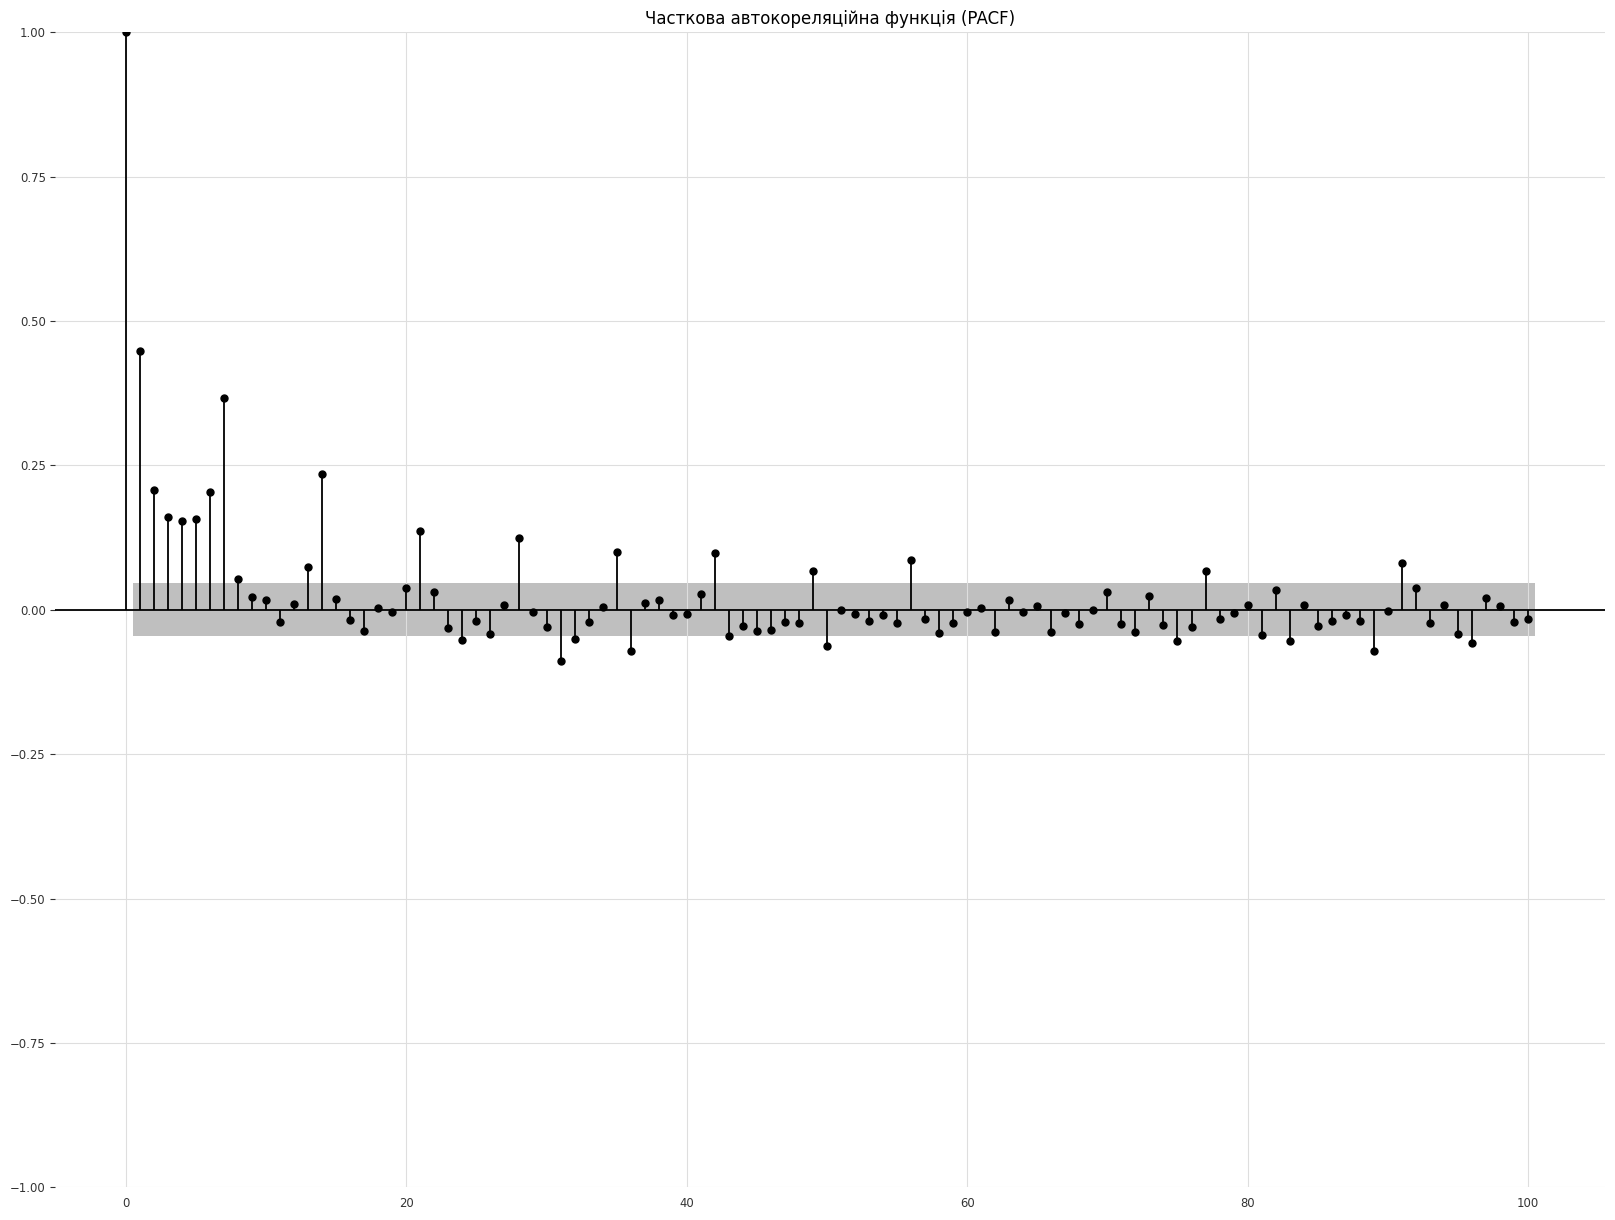

<Figure size 2000x1500 with 0 Axes>

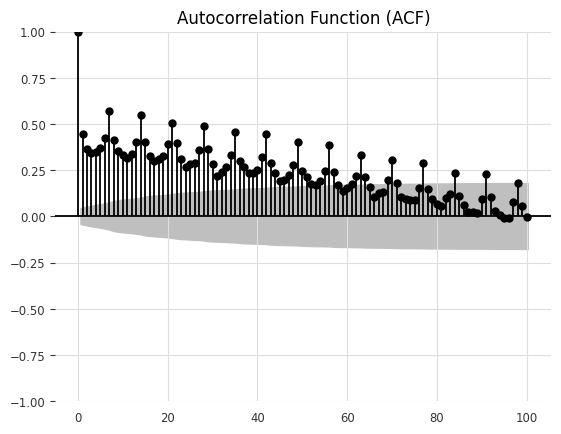

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plt.figure(figsize=(20, 15))
plot_pacf(sales_series.values(), lags=100, method='ywm', ax=plt.gca())
plt.title("Часткова автокореляційна функція (PACF)")
plt.show()

plt.figure(figsize=(20, 15))
plot_acf(sales_series.values(), lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()

1. На графіку часткової автокореляції спостерігається сильна автокореляція в межах перших 5 лагів.
2. Також прослідковується сезонність, кожен шостий лаг показує сильну автокореляцію.
3. На графіку ʼповноїʼ автокореляції також спостерігаємо сильну автокореляцію в межах перших 60 лагів і також є сезонність.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [11]:
from darts.utils.statistics import check_seasonality

seasonality = check_seasonality(train)

print(seasonality)

(True, 7)


Дані у нас представлені для кожного дня, тому тут ми спостерігаємо тижневу сезонність.

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

<Axes: xlabel='date'>

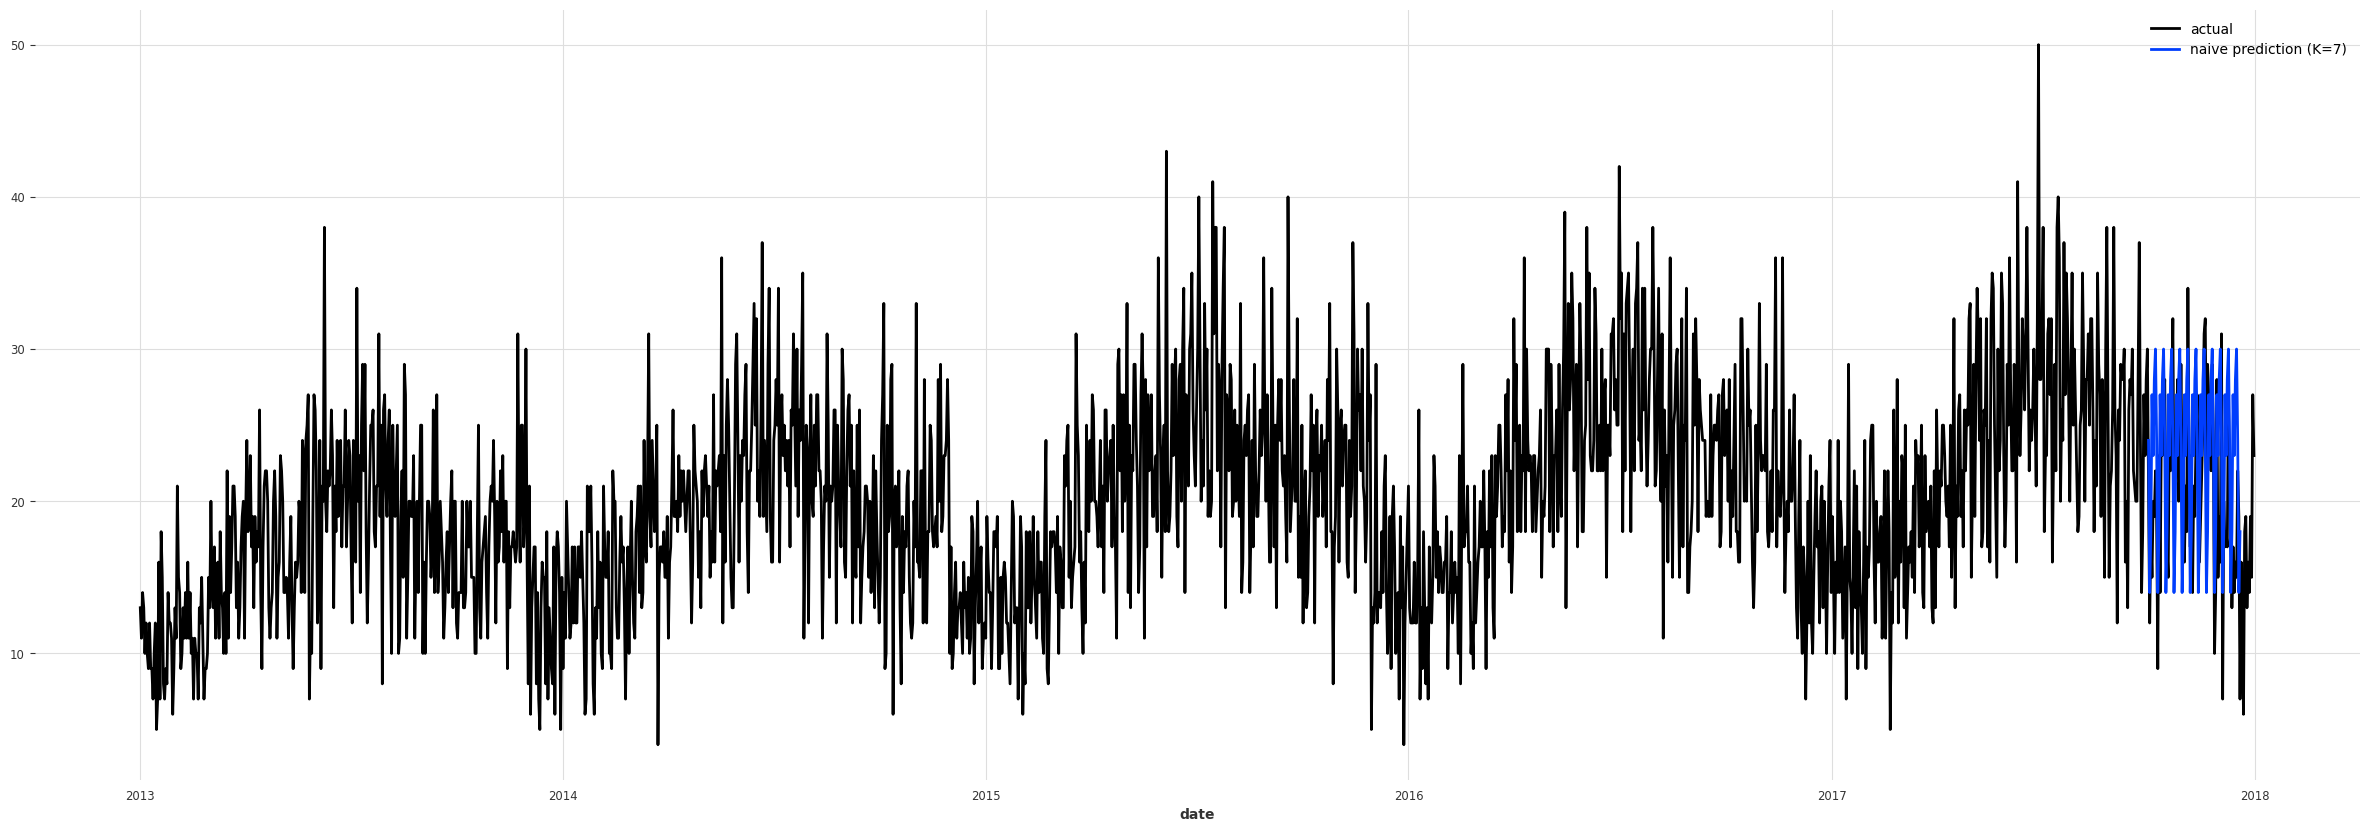

In [12]:
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift
import matplotlib.pyplot as plt

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(80)

plt.figure(figsize=(30, 10))
sales_series.plot(label="actual")
seasonal_forecast.plot(label="naive prediction (K=7)")

<Axes: xlabel='date'>

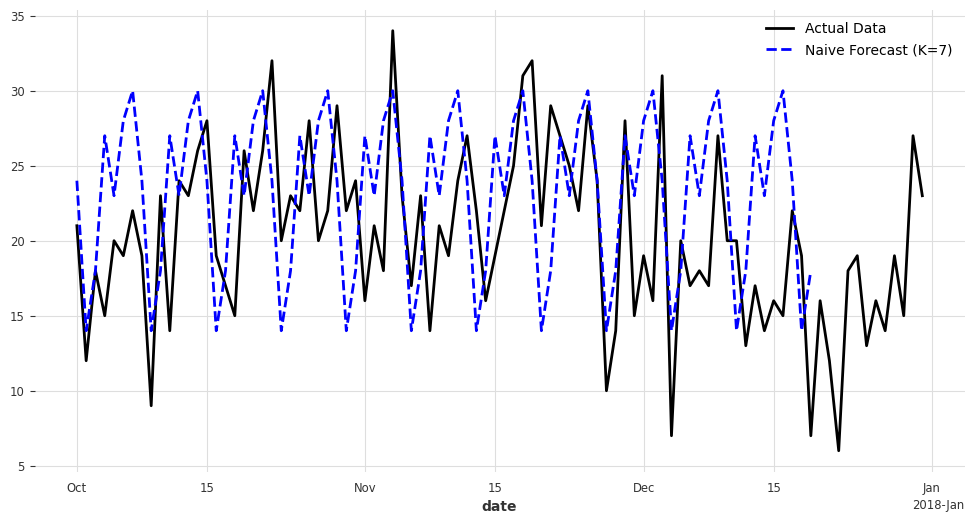

In [13]:
plt.figure(figsize=(12, 6))
val.plot(label="Actual Data", color='black')
seasonal_forecast.plot(label="Naive Forecast (K=7)", color='blue', linestyle='--')

<Axes: xlabel='date'>

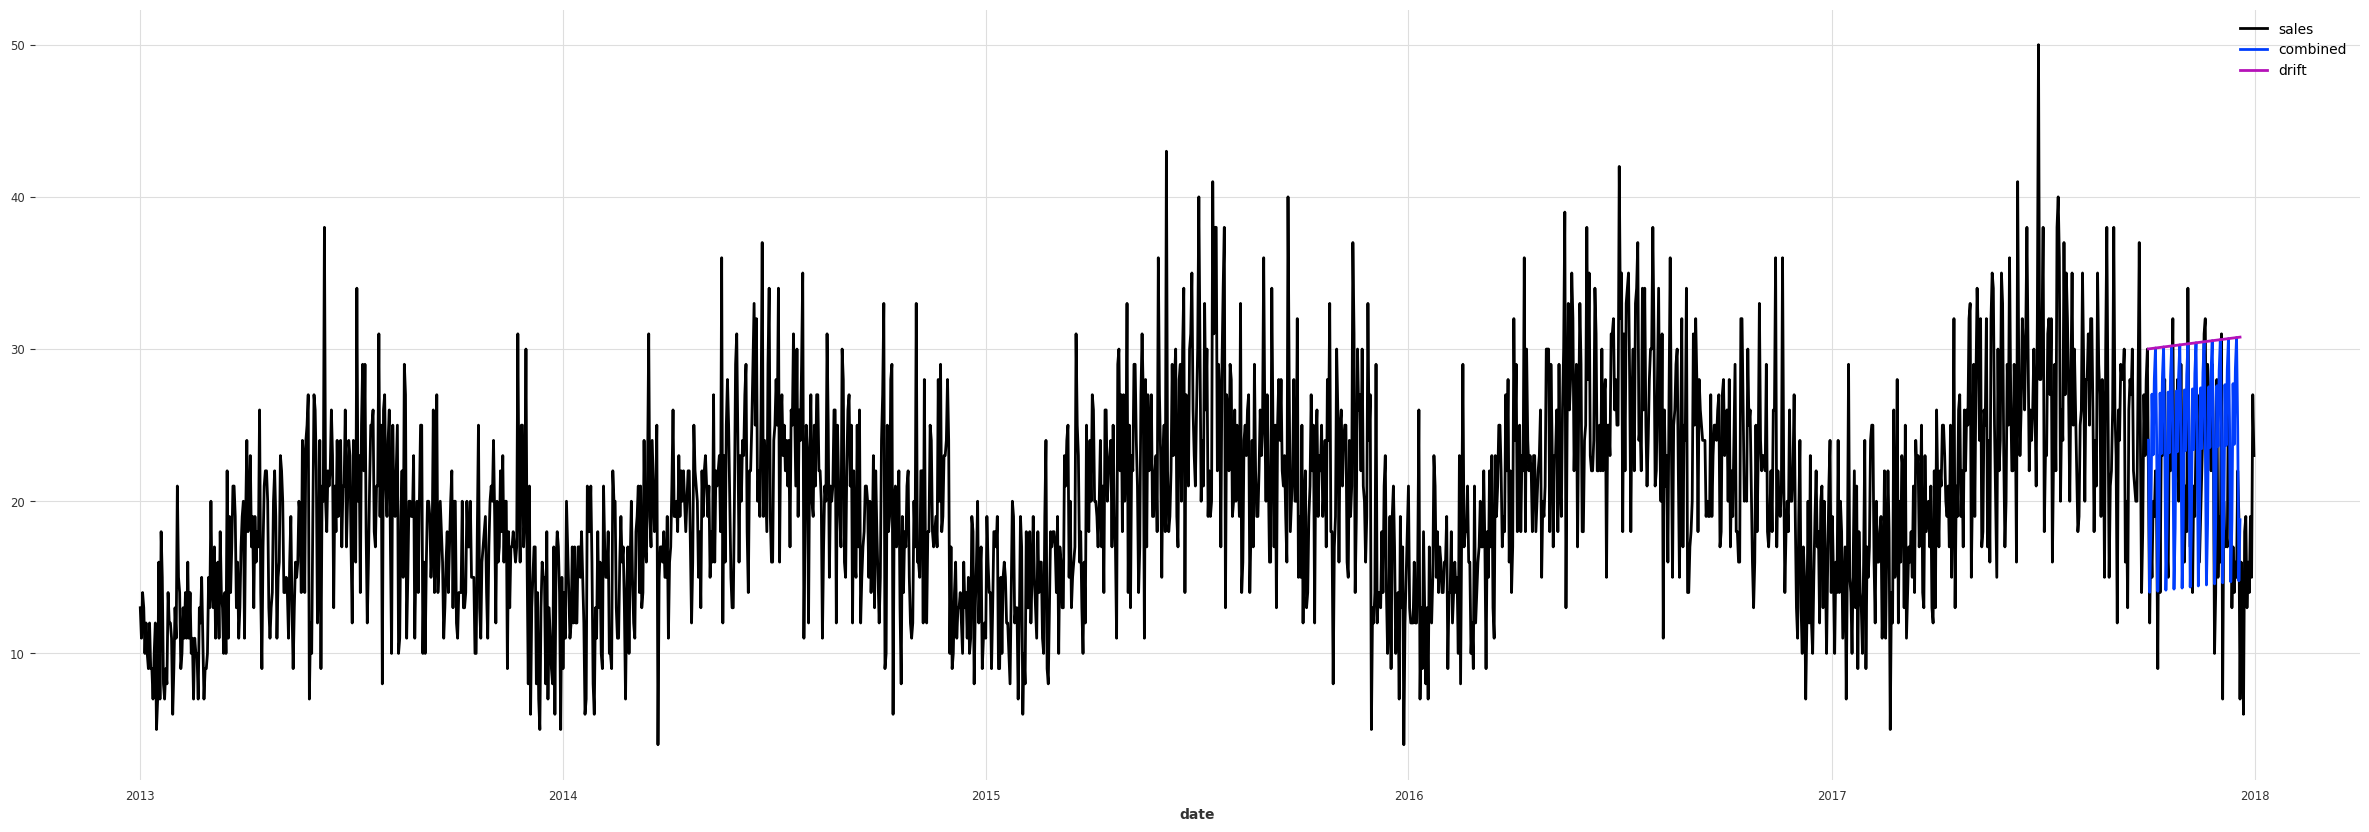

In [14]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(80)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

plt.figure(figsize=(30, 10))
sales_series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

<Axes: xlabel='date'>

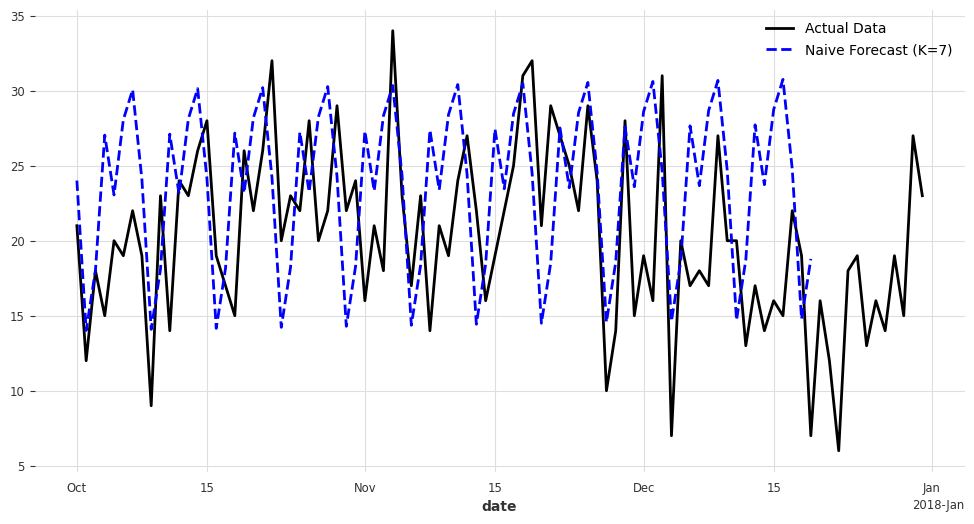

In [15]:
plt.figure(figsize=(12, 6))
val.plot(label="Actual Data", color='black')
combined_forecast.plot(label="Naive Forecast (K=7)", color='blue', linestyle='--')

1. Бачимо що моделі показали себе відносно непогано, враховується тижнева сезонність.
2. У комбінованій моделі присутній незначний висхідний тренд.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [16]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(sales_series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 34.31%.


Бачимо суттєву помилку у прогнозах.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

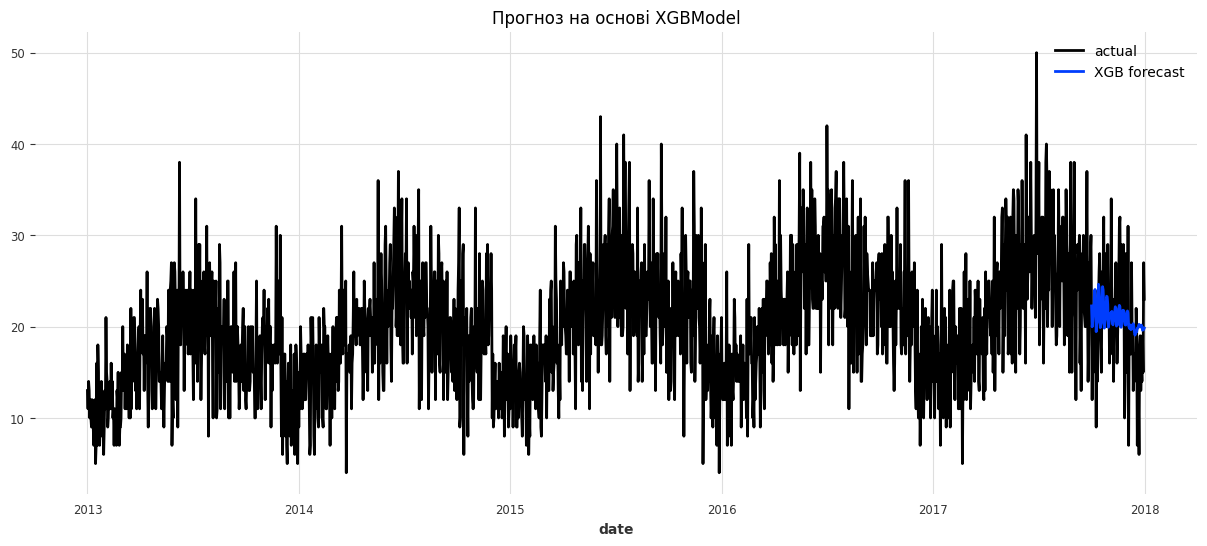

MAPE на валідаційних даних: 27.64%


In [17]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
import numpy as np

def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(val.pd_dataframe().reset_index())

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)

model = XGBModel(
    lags=7,
    output_chunk_length=32,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8
)

# model.fit(train)
model.fit(train_transformed)

# forecast = model.predict(len(val))
forecast = scaler.inverse_transform(model.predict(len(val)))

plt.figure(figsize=(15, 6))
sales_series.plot(label="actual")
forecast.plot(label="XGB forecast")
plt.legend()
plt.title("Прогноз на основі XGBModel")
plt.show()

mape_value = mape(val, forecast)
print(f'MAPE на валідаційних даних: {mape_value:.2f}%')


<Axes: xlabel='date'>

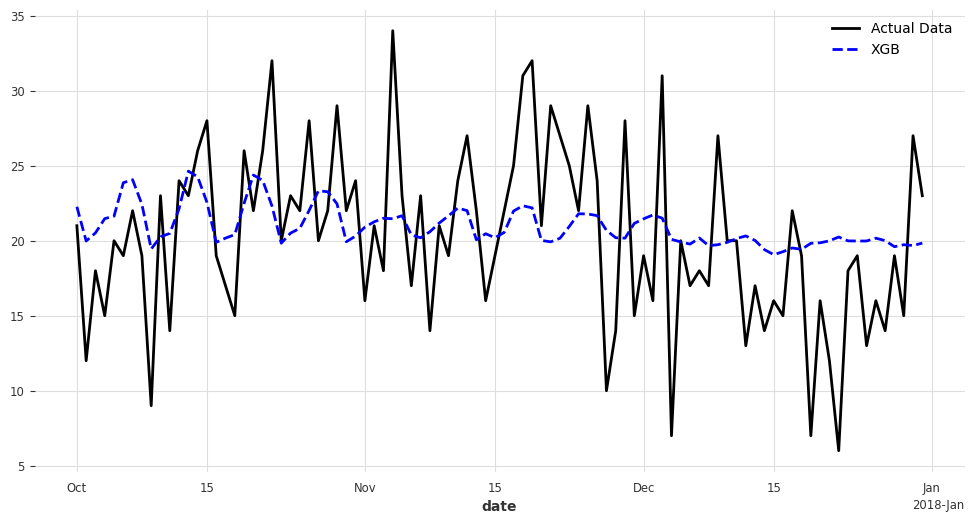

In [18]:
plt.figure(figsize=(12, 6))
val.plot(label="Actual Data", color='black')
forecast.plot(label="XGB", color='blue', linestyle='--')

На графіку виглядає, що модель прогнозує гірше попередньої, проте МAPE кращий. В той же час бачимо, що лінія прогнозу доволі згладжена, але в той же час здебільшого повторює кривизну справжніх значень.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [19]:
? ExponentialSmoothing

Object ` ExponentialSmoothing` not found.


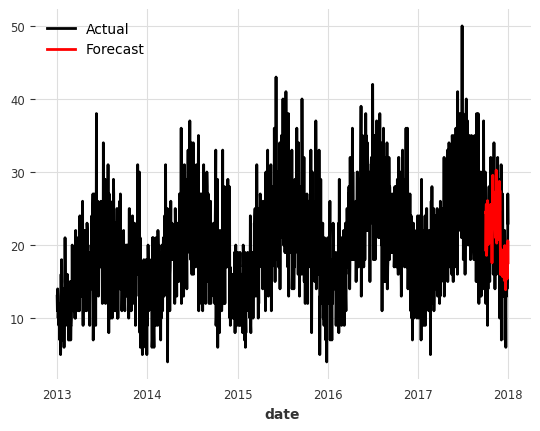

28.574500216303285


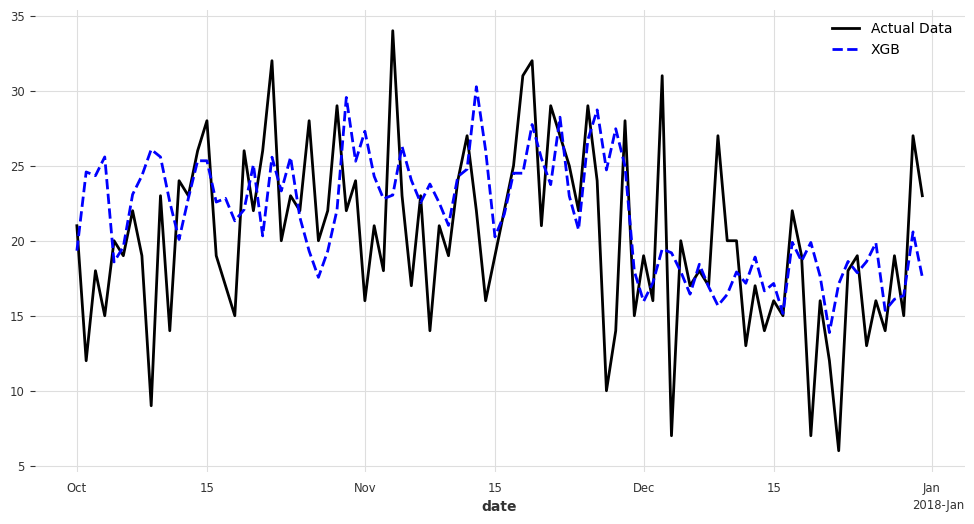

In [20]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode

def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  # forecast = model.predict(len(val))
  forecast = scaler.inverse_transform(model.predict(len(val)))
  plot_results(series, forecast)

  plt.figure(figsize=(12, 6))
  val.plot(label="Actual Data", color='black')
  forecast.plot(label="XGB", color='blue', linestyle='--')
  print(mape(val, forecast));


exp_smooth = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    damped=True,
    seasonal=SeasonalityMode.ADDITIVE,
    seasonal_periods=365
)


fit_and_plot(exp_smooth, sales_series, train_transformed, val)


Якість не змінилась, модель все ще показує не дуже хороші результати, хоча на перший погляд візуально краще.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


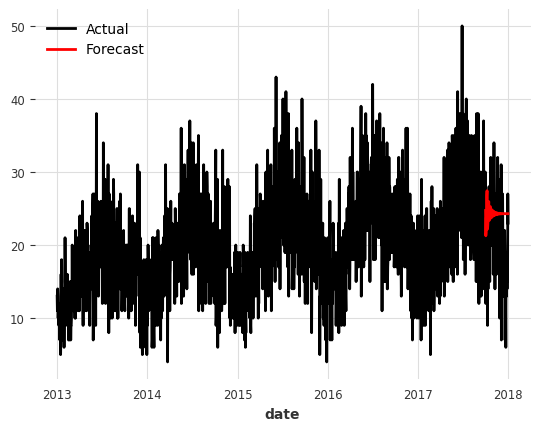

39.18166165665828


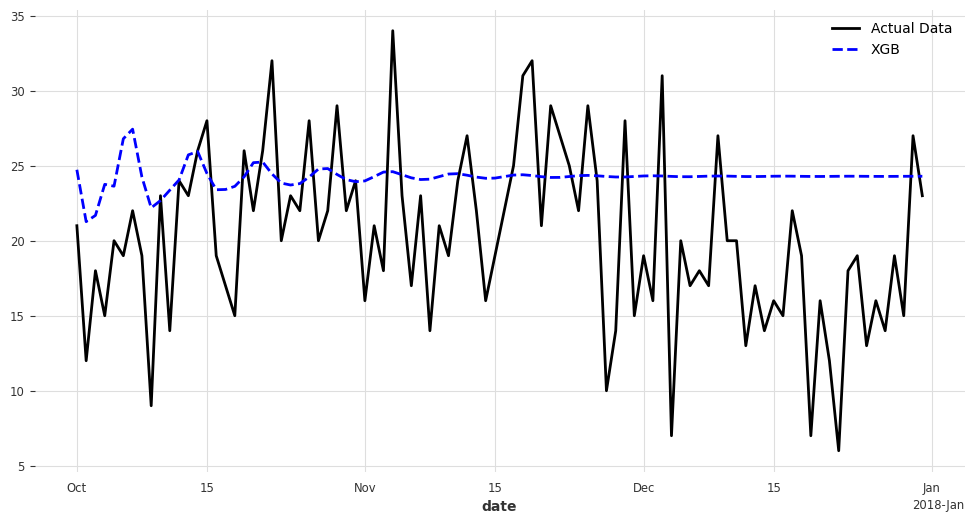

In [21]:
from darts.models import ARIMA

model = ARIMA(p=12, d=1, q=2)
fit_and_plot(model, sales_series, train_transformed, val)

Модель показала погані результати, при чому бачимо, що в кінці лінія передбачень згладжується

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=-2927.164, Time=5.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=-2618.194, Time=6.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=-2668.586, Time=2.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=-2852.456, Time=10.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=-2854.705, Time=9.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=-2514.207, Time=4.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=-2690.220, Time=10.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-2758.225, Time=7.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,2)[7] intercept   : AIC=-2872.771, Time=14.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2818.246, Time=7.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-2775.217, Time=6.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-2878.074, Time=7.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,1)[7] intercept   : AIC=-2778.174, Time=6.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[7]             : AIC=inf, Time=5.09 sec

Best model:  ARIMA(0,1,2)(1,0,1)[7] intercept
Total fit time: 278.239 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['supress_warnings']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


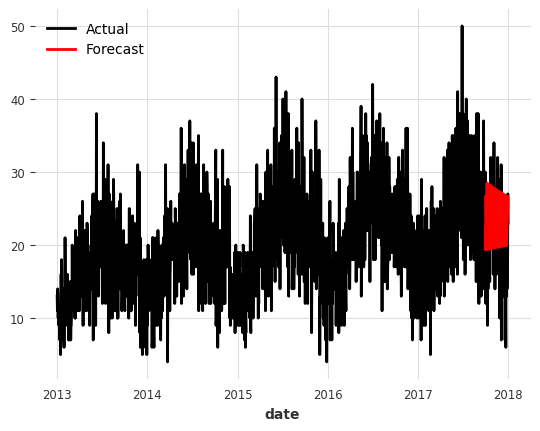

35.337142550875456


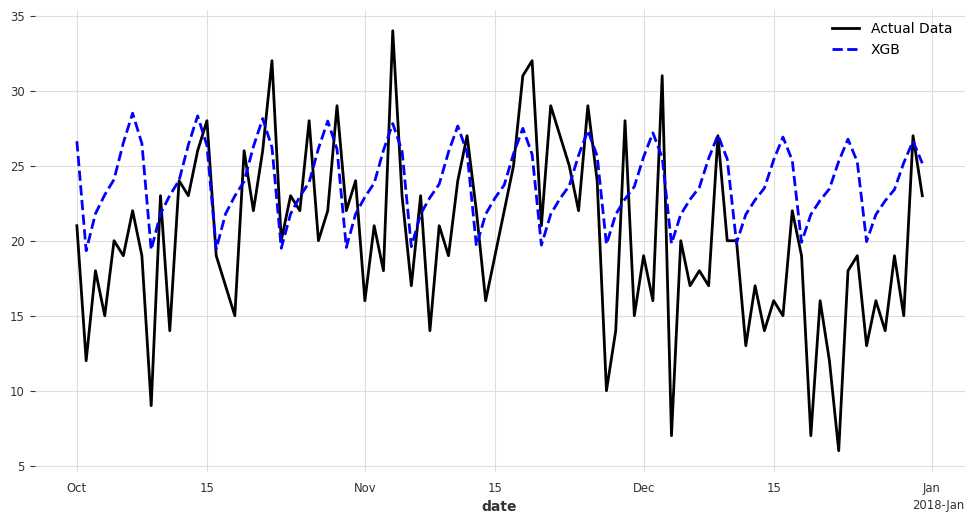

In [22]:
from darts.models import AutoARIMA
auto_arima_model = AutoARIMA(
    stepwise=True,
    trace=True,
    seasonal=True,
    m=7,
    supress_warnings=True)
fit_and_plot(auto_arima_model, sales_series, train_transformed, val)

In [23]:
auto_arima_model.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1734
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood                1469.582
Date:                             Tue, 11 Mar 2025   AIC                          -2927.164
Time:                                     14:41:09   BIC                          -2894.418
Sample:                                          0   HQIC                         -2915.053
                                            - 1734                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.303e-07   1.53e-05      0.048      0.962   -2.92e-05    3.06e-05
ma.L1         -0.9222      0.024    -38.004      0.000      -0.970      -0.875
ma.L2         -0.0178      0.025     -0.717      0.473      -0.066       0.031
ar.S.L7        0.9742      0.008    116.517      0.000       0.958       0.991
ma.S.L7       -0.8948      0.021    -43.310      0.000      -0.935      -0.854
sigma2         0.0108      0.000     30.986      0.000       0.010       0.012
===================================================================================
Ljung-Box (L1) (Q):                   3.69   Jarque-Bera (JB):                15.71
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAPE трохи краще, ніж у попередньої моделі, але загалом результати все ще досить погані.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [24]:
? Prophet

Object ` Prophet` not found.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7sjk52pr/86xe4y28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7sjk52pr/sbnv6hvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59945', 'data', 'file=/tmp/tmp7sjk52pr/86xe4y28.json', 'init=/tmp/tmp7sjk52pr/sbnv6hvi.json', 'output', 'file=/tmp/tmp7sjk52pr/prophet_model42_mi751/prophet_model-20250311144110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s

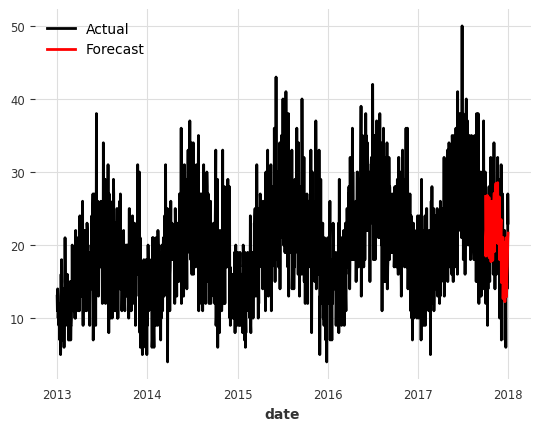

23.82687853938075


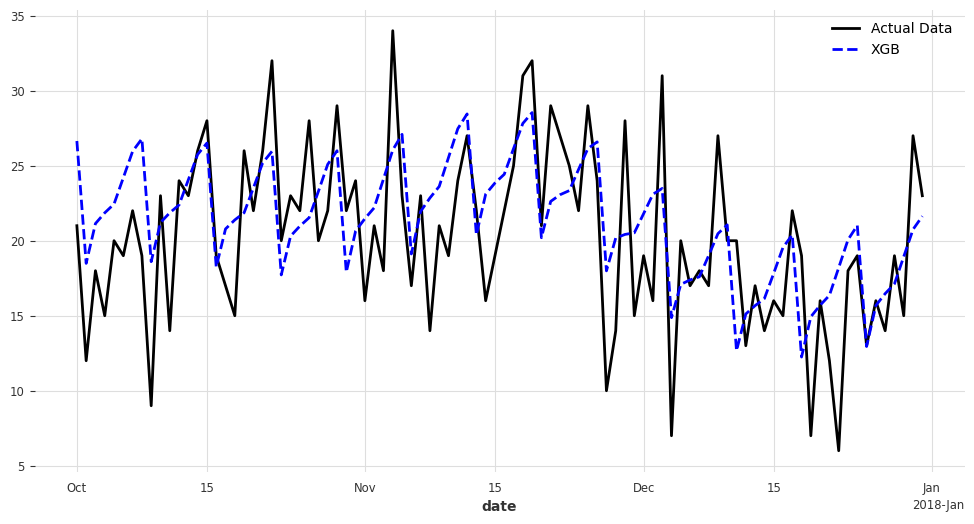

In [25]:
from darts.models import Prophet

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
)

prophet_model.fit(train_transformed)
fit_and_plot(prophet_model, sales_series, train_transformed, val)

Ця модель показала набагато кращі результати, загалом через те, що враховуються декілька сезонностай одночасно - тижнева та річна

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainab

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

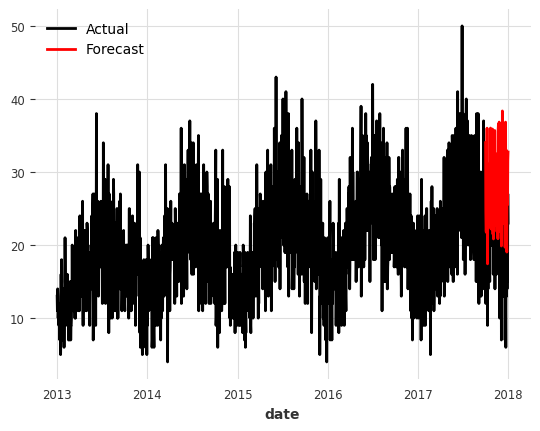

50.13411164170005


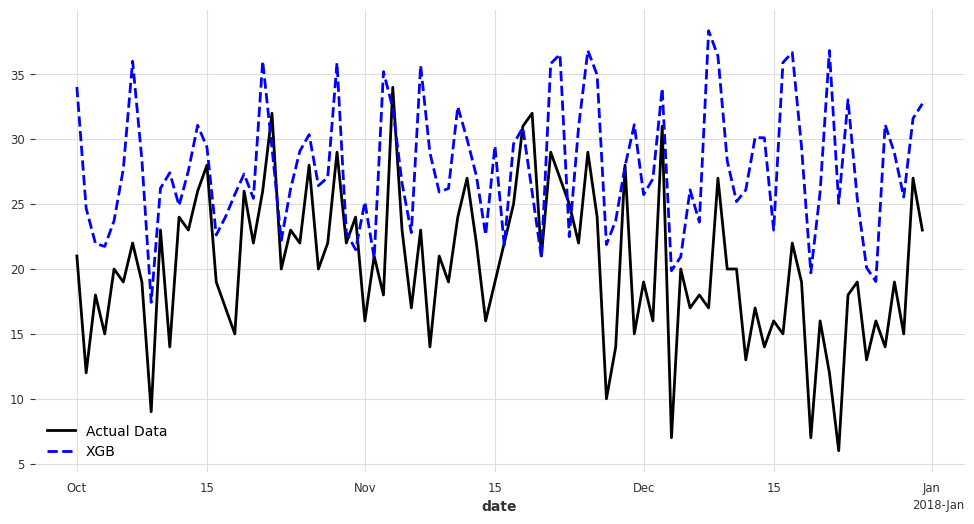

In [26]:
from darts.models import RNNModel

model_rnn = RNNModel(
    model="LSTM",
    input_chunk_length=14,
    output_chunk_length=7,
    hidden_dim=64,
    n_epochs=100,
    batch_size=16,
    random_state=42
)

fit_and_plot(model_rnn, sales_series, train_transformed, val)


Бачимо, що модель показала дуже погані результати.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7sjk52pr/8gmsc9ix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7sjk52pr/1n9emn4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40384', 'data', 'file=/tmp/tmp7sjk52pr/8gmsc9ix.json', 'init=/tmp/tmp7sjk52pr/1n9emn4g.json', 'output', 'file=/tmp/tmp7sjk52pr/prophet_modelal76o12n/prophet_model-20250311145252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7s

MAPE = 24.49%


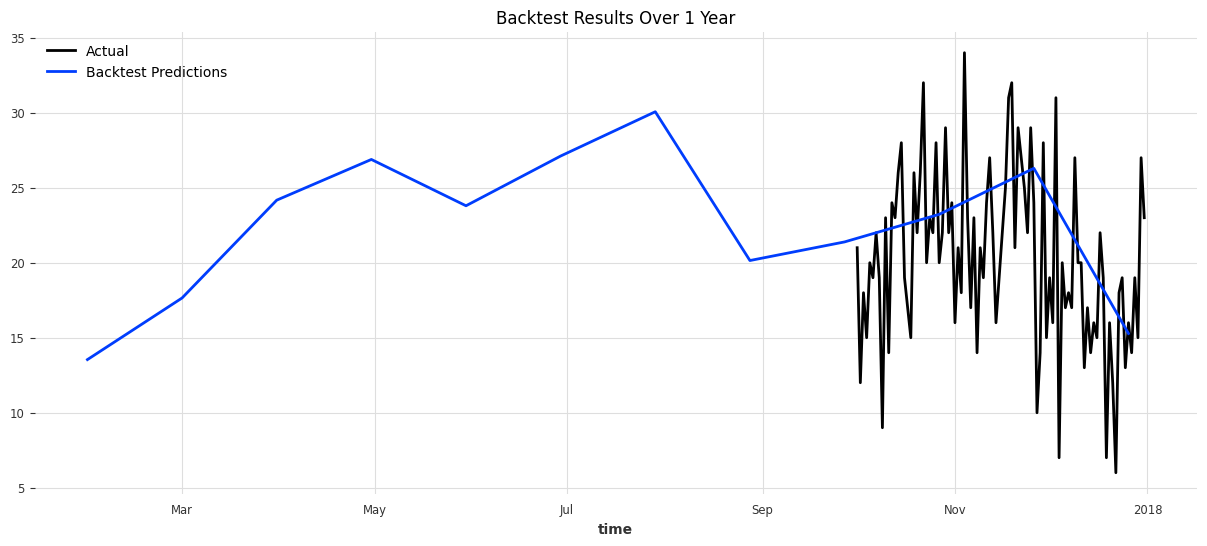

In [27]:
hfc_params = {
    "series": sales_series,
    "start": sales_series.time_index[-365],
    "forecast_horizon": 30,
    "stride": 30,
    "last_points_only": True,
    "verbose": False,
}

historical_fcast = prophet_model.historical_forecasts(**hfc_params)

plt.figure(figsize=(15, 6))
val.plot(label="Actual", linewidth=2)
historical_fcast.plot(label="Backtest Predictions")
plt.legend()
plt.title("Backtest Results Over 1 Year")

mape_score = mape(sales_series, historical_fcast)
print(f"MAPE = {mape_score:.2f}%")


Точність на бектесті та на валідаційних даних майже однакові. Загалом якість моделі не дуже хорошо, варто покращувати.

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Все залежить від конкретної задачі, якщо важливо виокремити дані по кожному конкретному товару в окремому магазині, то можна натренувати окремі моделі, але їх вийде  50 * 10 = 500. Це буде доволі затратно.
Якщо ж потрібно буде підрахувати загальні продажі, то можна тренувати або одну модель, або 50 чи 10 в залежності від того, чи потрібно передбачити загальні продажі конкретного товару в усіх магазинах, чи загальні продажі усіх товарів в конкретному магазині відповідно.
Також можна спробувати зробити одну загальну модель (або ж згрупувати по певним ознакам, наприклад певні групи товарів зі схожими тенденціями).

В домашньому завданні найкращі результати показали XGB та Prophet. Можна почати з них, але провести експерименти й з іншими моделями.